In [ ]:
# Some tests that calculate known geometric quantities

# restart the kernel to clear past work
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import time
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline

# homemade code
sys.path.append('../')
from source.mytests import *                   # go here to change the test conditions

# Input parameters for grid and evolution here
N_r = 100 # num points on physical grid
R = 8.0 # Maximum outer radius
num_ghosts = 3
N = N_r + 2 * num_ghosts

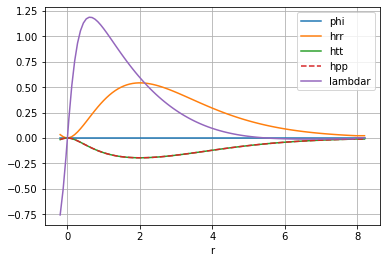

In [2]:
# This test sets up values such that R is known but phi = 0
r, initial_state = get_test_state_1(R, N_r)

#unpackage the vector for readability
u, v , phi, hrr, htt, hpp, K, arr, att, app, lambdar, shiftr, br, lapse = np.array_split(initial_state, NUM_VARS)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, phi, label='phi')
plt.plot(r, hrr, label='hrr')
plt.plot(r, htt, label='htt')
plt.plot(r, hpp, '--', label='hpp')
plt.plot(r, lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

In [3]:
# calculate the diagnostics, the Ham constraint should just have 
# the term in bar_R so this tests the calculation of that quantity

# Set up grid values
dx = R/N_r
oneoverdx  = 1.0 / dx
oneoverdxsquared = oneoverdx * oneoverdx

# get the various derivs that we need to evolve things in vector form
# second derivatives
d2phidx2   = get_d2fdx2(phi, oneoverdxsquared)
d2hrrdx2   = get_d2fdx2(hrr, oneoverdxsquared)
d2httdx2   = get_d2fdx2(htt, oneoverdxsquared)
d2hppdx2   = get_d2fdx2(hpp, oneoverdxsquared)

# first derivatives
dphidx     = get_dfdx(phi, oneoverdx)
dhrrdx     = get_dfdx(hrr, oneoverdx)
dhttdx     = get_dfdx(htt, oneoverdx)
dhppdx     = get_dfdx(hpp, oneoverdx)
dlambdardx = get_dfdx(lambdar, oneoverdx)

bar_R_test = np.zeros_like(phi)
chris_rrr  = np.zeros_like(phi)
chris_ttr  = np.zeros_like(phi)
chris_ppr  = np.zeros_like(phi)
Ricci_rr   = np.zeros_like(phi)
Ricci_tt   = np.zeros_like(phi)
Ricci_pp   = np.zeros_like(phi)

h_tensor = np.array([hrr, htt, hpp])
a_tensor = np.array([arr, att, app])
em4phi = np.exp(-4.0*phi)
dhdr   = np.array([dhrrdx, dhttdx, dhppdx])
d2hdr2 = np.array([d2hrrdx2, d2httdx2, d2hppdx2])
    
# Calculate some useful quantities
########################################################

# \hat \Gamma^i_jk
flat_chris = get_flat_spherical_chris(r)

# (unscaled) \bar\gamma_ij and \bar\gamma^ij
bar_gamma_LL = get_metric(r, h_tensor)
bar_gamma_UU = get_inverse_metric(r, h_tensor)

# The connections Delta^i, Delta^i_jk and Delta_ijk
Delta_U, Delta_ULL, Delta_LLL  = get_connection(r, bar_gamma_UU, bar_gamma_LL, h_tensor, dhdr)
    
conformal_chris = get_conformal_chris(Delta_ULL, r)  
chris_rrr = conformal_chris[i_r][i_r][i_r][:]
chris_ttr = conformal_chris[i_t][i_t][i_r][:]
chris_ppr = conformal_chris[i_p][i_p][i_r][:] 
    
bar_Rij = get_ricci_tensor(r, h_tensor, dhdr, d2hdr2, lambdar, dlambdardx, 
                           Delta_U, Delta_ULL, Delta_LLL, bar_gamma_UU, bar_gamma_LL)
            
Ricci_rr = bar_Rij[i_r][i_r]
Ricci_tt = bar_Rij[i_t][i_t]
Ricci_pp = bar_Rij[i_p][i_p]

bar_Ricci_tensor = np.array([Ricci_rr,Ricci_tt,Ricci_pp])
bar_R_test = get_trace(bar_Ricci_tensor, bar_gamma_UU)

r_diagnostics = r[num_ghosts:(N-num_ghosts)]

In [4]:
# Calculate the rescaled quantities for comparison
########################################################

# rescaled \bar\gamma_ij and \bar\gamma^ij
r_gamma_LL = get_rescaled_metric(h_tensor)
r_gamma_UU = get_rescaled_inverse_metric(h_tensor)
        
# \bar A_ij, \bar A^ij and the trace A_i^i, then Asquared = \bar A_ij \bar A^ij
a_UU = get_a_UU(a_tensor, r_gamma_UU)
traceA   = get_trace_A(a_tensor, r_gamma_UU)
Asquared = get_Asquared(a_tensor, r_gamma_UU)
        
# The rescaled connections Delta^i, Delta^i_jk and Delta_ijk
rDelta_U, rDelta_ULL, rDelta_LLL  = get_rescaled_connection(r, r_gamma_UU, 
                                                                r_gamma_LL, h_tensor, dhdr)
# rescaled \bar \Gamma^i_jk
r_conformal_chris = get_rescaled_conformal_chris(rDelta_ULL, r)
r_chris_rrr = r_conformal_chris[i_r][i_r][i_r][:]
r_chris_ttr = r_conformal_chris[i_t][i_t][i_r][:]
r_chris_ppr = r_conformal_chris[i_p][i_p][i_r][:]

# rescaled Ricci tensor
rbar_Rij = get_rescaled_ricci_tensor(r, h_tensor, dhdr, d2hdr2, lambdar, dlambdardx,
                                         rDelta_U, rDelta_ULL, rDelta_LLL, 
                                         r_gamma_UU, r_gamma_LL)

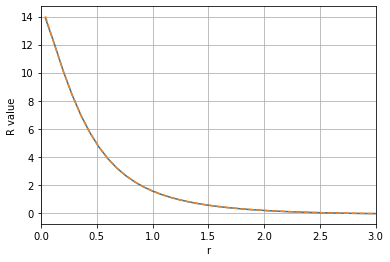

In [5]:
# Plot the Ricci scalar
bar_R_plot = bar_R_test[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, bar_R_plot)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
tmp = (1.0 + x*x/epowr)**(0.5)
R_analytic = (1.0 / 8.0 / (x*x) * (epowr + x*x)**(-3.0) * 
              (16.0 * (x**6.0) * tmp
               - epowr * (x**4.0) * (-20.0  + 12.0*x + 7.0*x*x - 48.0*tmp)
               + 16.0 * epowr**3.0 * (-1.0 + tmp)
               + 8.0 * epowr**2.0 * x*x * (8.0 - 9.0*x + x*x + 6 * tmp)))

plt.plot(x, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('R value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

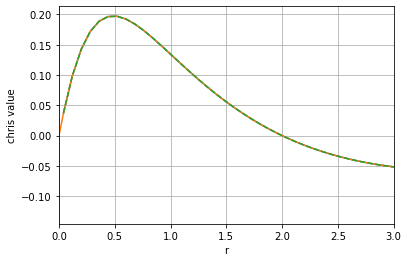

In [6]:
# Plot christoffels
chris_rrr_d = chris_rrr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, chris_rrr_d)
plt.plot(r,r_chris_rrr)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
chris_rrr_analytic = -(0.5 * x * (x-2.0) / (epowr + x*x))
plt.plot(x, chris_rrr_analytic, '--')

plt.xlabel('r')
plt.ylabel('chris value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

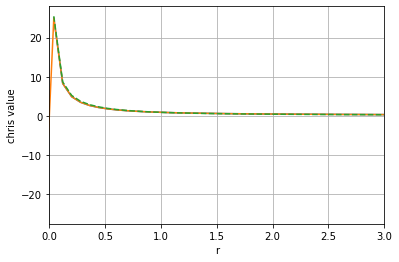

In [7]:
# Plot christoffels
chris_ttr_d = chris_ttr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, chris_ttr_d)
plt.plot(r,r_chris_ttr)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
chris_ttr_analytic = (( 4.0 * epowr + 2.0*x + x**3.0 ) / (4.0 * x * epowr + 4.0 * x**3.0))
plt.plot(x, chris_ttr_analytic, '--')
#plt.plot(x, 1.0/x, '--')

plt.xlabel('r')
plt.ylabel('chris value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

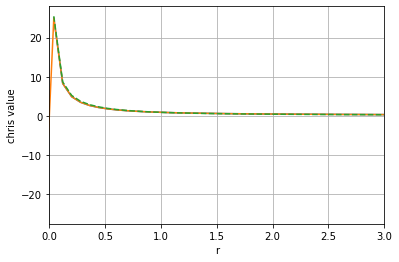

In [8]:
# Plot christoffels
chris_ppr_d = chris_ppr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, chris_ppr_d)
plt.plot(r,r_chris_ppr)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
chris_ppr_analytic = chris_ttr_analytic
plt.plot(x, chris_ppr_analytic, '--')

plt.xlabel('r')
plt.ylabel('chris value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

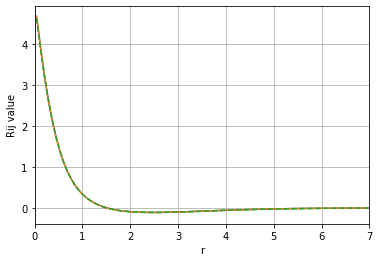

In [16]:
# Plot comps of Ricci - R_rr
Ricci_ij_d = Ricci_rr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ricci_ij_d)
plt.plot(r, rbar_Rij[i_r][i_r])

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
Ricci_analytic = ( (1.0/8.0) * (epowr + x*x)**-2.0 
              * ( x*x * (12 - 4.0*x - 3.0*x*x) 
                  + 4.0 * epowr * (10.0 - 8.0*x + x*x)))
plt.plot(x, Ricci_analytic, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,7)
#plt.ylim(0,1)
plt.grid()

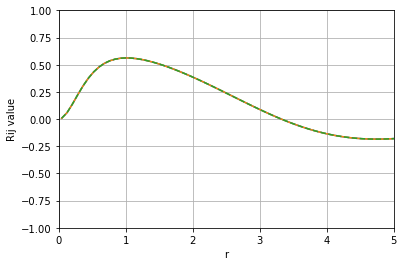

In [17]:
# Plot comps of Ricci - R_tt
Ricci_ij_d = Ricci_tt[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ricci_ij_d)
plt.plot(r_diagnostics, r_diagnostics * r_diagnostics * rbar_Rij[i_t][i_t][num_ghosts:(N-num_ghosts)])

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
tmp = (1.0 + x*x/epowr)**(0.5)
Ricci_analytic_tt = ( 0.25 * epowr**2.0 * tmp * ((epowr + x*x)**(-4.0))
                  * ( -4.0 * epowr**2.0 
                     + epowr * x**2.0 * (6.0 -10.0*x +x*x) 
                     - x**4.0 * (-2.0 + 2.0*x + x*x))) + 1.0
plt.plot(x, Ricci_analytic_tt, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,5)
plt.ylim(-1,1)
plt.grid()

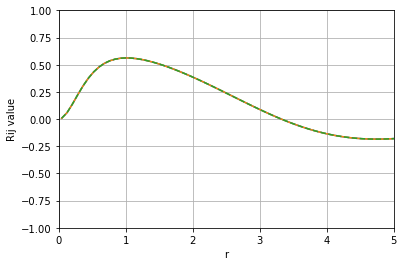

In [18]:
# Plot comps of Ricci - R_pp
Ricci_ij_d = Ricci_pp[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ricci_ij_d)
plt.plot(r_diagnostics, r_diagnostics * r_diagnostics * rbar_Rij[i_p][i_p][num_ghosts:(N-num_ghosts)])

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
Ricci_analytic_pp = Ricci_analytic_tt
plt.plot(x, Ricci_analytic_pp, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,5)
plt.ylim(-1,1)
plt.grid()

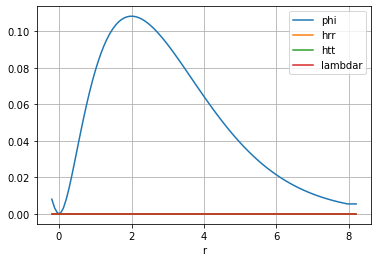

In [19]:
# This test sets up values such that R is known but bar_R = 0
r, initial_state = get_test_state_2(R, N_r)

#unpackage the vector for readability
u, v , phi, hrr, htt, hpp, K, arr, att, app, lambdar, shiftr, br, lapse = np.array_split(initial_state, NUM_VARS)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, phi, label='phi')
plt.plot(r, hrr, label='hrr')
plt.plot(r, htt, label='htt')
plt.plot(r, lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

In [20]:
# Set up grid values
dx = R/N_r
oneoverdx  = 1.0 / dx
oneoverdxsquared = oneoverdx * oneoverdx

# get the various derivs that we need to evolve things in vector form
# second derivatives
d2phidx2   = get_d2fdx2(phi, oneoverdxsquared)
d2hrrdx2   = get_d2fdx2(hrr, oneoverdxsquared)
d2httdx2   = get_d2fdx2(htt, oneoverdxsquared)
d2hppdx2   = get_d2fdx2(hpp, oneoverdxsquared)

# first derivatives
dphidx     = get_dfdx(phi, oneoverdx)
dhrrdx     = get_dfdx(hrr, oneoverdx)
dhttdx     = get_dfdx(htt, oneoverdx)
dhppdx     = get_dfdx(hpp, oneoverdx)
dlambdardx = get_dfdx(lambdar, oneoverdx)

bar_R_test = np.zeros_like(phi)
chris_rrr  = np.zeros_like(phi)
chris_ttr  = np.zeros_like(phi)
chris_ppr  = np.zeros_like(phi)
Ricci_rr   = np.zeros_like(phi)
Ricci_tt   = np.zeros_like(phi)
Ricci_pp   = np.zeros_like(phi)

h_tensor = np.array([hrr, htt, hpp])
a_tensor = np.array([arr, att, app])
em4phi = np.exp(-4.0*phi)
dhdr   = np.array([dhrrdx, dhttdx, dhppdx])
d2hdr2 = np.array([d2hrrdx2, d2httdx2, d2hppdx2])
    
# Calculate some useful quantities
########################################################

# \hat \Gamma^i_jk
flat_chris = get_flat_spherical_chris(r)

# (unscaled) \bar\gamma_ij and \bar\gamma^ij
bar_gamma_LL = get_metric(r, h_tensor)
bar_gamma_UU = get_inverse_metric(r, h_tensor)
    
# The connections Delta^i, Delta^i_jk and Delta_ijk
Delta_U, Delta_ULL, Delta_LLL  = get_connection(r, bar_gamma_UU, bar_gamma_LL, h_tensor, dhdr)
    
conformal_chris = get_conformal_chris(Delta_ULL, r)  
chris_rrr = conformal_chris[i_r][i_r][i_r][:]
chris_ttr = conformal_chris[i_t][i_t][i_r][:]
chris_ppr = conformal_chris[i_p][i_p][i_r][:] 
    
bar_Rij = get_ricci_tensor(r, h_tensor, dhdr, d2hdr2, lambdar, dlambdardx, 
                           Delta_U, Delta_ULL, Delta_LLL, bar_gamma_UU, bar_gamma_LL)
            
Ricci_rr = bar_Rij[i_r][i_r]
Ricci_tt = bar_Rij[i_t][i_t]
Ricci_pp = bar_Rij[i_p][i_p]

bar_Ricci_tensor = np.array([Ricci_rr,Ricci_tt,Ricci_pp])
bar_R_test = get_trace(bar_Ricci_tensor, bar_gamma_UU)

r_diagnostics = r[num_ghosts:(N-num_ghosts)]
    
# Get the Ham constraint eqn (13) of Baumgarte https://arxiv.org/abs/1211.6632
Ham_test = em4phi * ( bar_R_test #should be zero
                           - 8.0 * bar_gamma_UU[i_r][i_r] * (dphidx * dphidx + d2phidx2)
                           # These terms come from \bar\Gamma^r d_r \phi from the \bar D^2 \phi term
                           + 8.0 * bar_gamma_UU[i_t] * dphidx * flat_chris[i_r][i_t][i_t]
                           + 8.0 * bar_gamma_UU[i_p] * dphidx * flat_chris[i_r][i_p][i_p]
                           + 8.0 * Delta_U[i_r] * dphidx) #should be zero

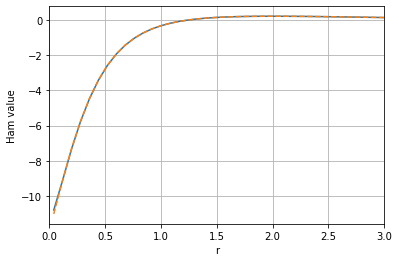

In [21]:
# Plot the result
Ham_plot = Ham_test[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ham_plot)

#analytic result for test 2
epowr = np.exp(r_diagnostics)
x = r_diagnostics
R_analytic = - (0.5 * epowr * (epowr + x*x)**-3.0 
              * ( x*x * (12.0 - 12.0*x + x*x) 
                 + 4.0 * epowr * (6.0 - 6.0* x + x*x)))


plt.plot(x, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('Ham value')
plt.xlim(0,3)
#plt.ylim(-12,1)
plt.grid()